Implementation from https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO_colab.ipynb

In [ ]:
import os
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from cathedral_rl import cathedral_v0  
import random
import numpy as np

In [10]:
################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")



Device set to : NVIDIA RTX A5000


In [ ]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
        self.action_masks = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]
        del self.action_masks[:]


class ActorCritic(nn.Module):
    def __init__(self, obs_shape, action_dim):
        super(ActorCritic, self).__init__()
        
        # Calculate input size from observation shape
        self.state_dim = obs_shape[0] * obs_shape[1] * obs_shape[2]  # Flattened input
        self.action_dim = action_dim

        # Actor network - outputs action probabilities
        self.actor = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
            # No softmax here - will apply it with action mask later
        )
        
        # Critic network - outputs state value
        self.critic = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, action_mask):
        # Flatten state for linear layers
        state_flat = state.reshape(-1)
        
        # Get action logits from actor
        action_logits = self.actor(state_flat)
        
        # Apply action mask (set invalid actions to negative infinity)
        action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)
        action_logits[~action_mask_tensor] = float('-inf')
        
        # Apply softmax to get action probabilities
        action_probs = torch.softmax(action_logits, dim=0)
        
        # Create categorical distribution
        dist = Categorical(action_probs)
        
        # Sample action
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        # Get state value from critic
        state_val = self.critic(state_flat)
        
        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, states, actions, action_masks):
        # Flatten states for linear layers
        batch_size = states.shape[0]
        states_flat = states.reshape(batch_size, -1)
        
        # Get action logits from actor for all states
        action_logits = self.actor(states_flat)
        
        # Apply action masks (set invalid actions to negative infinity)
        for i in range(batch_size):
            action_mask = action_masks[i]
            action_logits[i][~action_mask] = float('-inf')
        
        # Apply softmax to get action probabilities
        action_probs = torch.softmax(action_logits, dim=1)
        
        # Create categorical distributions
        dist = Categorical(action_probs)
        
        # Get log probabilities, entropies, and state values
        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        state_values = self.critic(states_flat)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, obs_shape, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()
        
        self.policy = ActorCritic(obs_shape, action_dim).to(device)
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        
        self.policy_old = ActorCritic(obs_shape, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, action_mask):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            action_mask_tensor = torch.BoolTensor(action_mask).to(device)
            action, action_logprob, state_val = self.policy_old.act(state_tensor, action_mask_tensor)
        
        self.buffer.states.append(state_tensor)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)
        self.buffer.action_masks.append(action_mask_tensor)
        
        return action.item()
    
    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards (if there are any)
        if len(rewards) > 0:
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            if rewards.std() > 0:
                rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        else:
            return  # Nothing to update if buffer is empty
        
        # Convert lists to tensors
        old_states = torch.stack(self.buffer.states).detach().to(device)
        old_actions = torch.stack(self.buffer.actions).detach().to(device)
        old_logprobs = torch.stack(self.buffer.logprobs).detach().to(device)
        old_state_values = torch.stack(self.buffer.state_values).detach().squeeze().to(device)
        old_action_masks = torch.stack(self.buffer.action_masks).detach().to(device)
        
        # Calculate advantages
        advantages = rewards - old_state_values
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions, old_action_masks)
            
            # Match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            
            # Final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # Clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
    
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [12]:
has_continuous_action_space = False

K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001 

In [13]:
board_size = 10
num_episodes = 200
save_freq = 50
factor_illegal_action = 1

In [ ]:
def train_ppo_self_play(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()
    
    # Get action space and observation shape (should be the same for both players)
    player_0 = "player_0"
    player_1 = "player_1"
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape  # (10, 10, 5)
    
    print(f'n_actions: {n_actions}')
    print(f'observation shape: {obs_shape}')
    
    # Initialize PPO agent (will be used for both players)
    ppo_agent = PPO(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Training statistics
    list_reward_p0 = []
    list_reward_p1 = []
    list_win_rate_p0 = []
    policy_checkpoints = []
    win_count_p0 = 0
    draw_count = 0
    
    # Training loop
    for episode in range(num_episodes):
        print(f'Episode {episode}')
        env.reset()
        total_reward_p0 = 0
        total_reward_p1 = 0
        episode_timesteps = 0
        
        # Clear player buffer
        ppo_agent.buffer.clear()
        
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            state = observation["observation"]
            action_mask = observation["action_mask"]
            
            # Both players use PPO to select actions
            action = ppo_agent.select_action(state, action_mask)
            
            # Take action in environment
            env.step(action)
            
            # Get reward
            reward = env.rewards[current_agent]
            
            # Track total rewards
            if current_agent == player_0:
                total_reward_p0 += reward
            else:
                total_reward_p1 += reward
            
            # Store reward in appropriate buffer
            ppo_agent.buffer.rewards.append(reward)
            
            # Check if episode is done
            if current_agent not in env.agents:
                ppo_agent.buffer.is_terminals.append(1)
            else:
                ppo_agent.buffer.is_terminals.append(0)
            
            episode_timesteps += 1
        
        print(f'Timesteps of the episode {episode_timesteps}')
        
        # Update PPO policy using both players' experiences
        if episode >= 10:  # Start updating after collecting some experience
            # Combine experiences from both players
            ppo_agent.update()
        
        # Collect statistics
        print(f'Total rewards p0 {total_reward_p0} and p1 {total_reward_p1}')
        list_reward_p0.append(total_reward_p0)
        list_reward_p1.append(total_reward_p1)
        
        # Track wins for player_0 (for consistency with the old tracking)
        if env.winner == 0:  # player_0 wins
            win_count_p0 += 1
        elif env.winner == -1:  # draw
            draw_count += 1
        
        if (episode + 1) % 100 == 0:
            win_rate_p0 = win_count_p0 / 100
            draw_rate = draw_count / 100
            list_win_rate_p0.append(win_rate_p0)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Player 0 - Avg Reward: {sum(list_reward_p0[-100:]) / 100:.2f} - Win Rate: {win_rate_p0:.2f}")
            print(f"  Player 1 - Avg Reward: {sum(list_reward_p1[-100:]) / 100:.2f} - Win Rate: {(100 - win_count_p0 - draw_count) / 100:.2f}")
            print(f"  Draw Rate: {draw_rate:.2f}")
            
            # Reset counters
            win_count_p0 = 0
            draw_count = 0
        
        # Save checkpoint
        if (episode+1) % save_freq == 0:
            policy_checkpoints.append(ppo_agent.policy.state_dict())
            print("Checkpoint saved")
            
            # Save model
            os.makedirs("model_weights_PPO", exist_ok=True)
            ppo_agent.save(f"model_weights_PPO/{name}_{episode+1}.pth")
    
    # Save final model and training statistics
    os.makedirs("model_weights_PPO", exist_ok=True)
    torch.save({
        'model_state_dict': ppo_agent.policy.state_dict(),
        'list_reward_p0': list_reward_p0,
        'list_reward_p1': list_reward_p1,
        'list_win_rate_p0': list_win_rate_p0,
        'policy_checkpoints': policy_checkpoints,
        'num_checkpoints': len(policy_checkpoints)
    }, f"model_weights_PPO/{name}_final.pth")
    
    env.close()
    
    return list_reward_p0, list_reward_p1, list_win_rate_p0

n_actions: 2969
observation shape: (10, 10, 5)
Episode 0


/tmp/ipykernel_1848969/1817146538.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)


Took action 2815
Reward before penalty 0
Took action 1293
Reward before penalty -2
Took action 2429
Reward before penalty 0
Took action 107
Reward before penalty -4
Took action 537
Reward before penalty -3
Took action 86
Reward before penalty -4
Took action 151
Reward before penalty -4
Took action 348
Reward before penalty -3
Took action 1384
Reward before penalty -1
Took action 1919
Reward before penalty 0
Took action 2074
Reward before penalty 3
Took action 1808
Reward before penalty -1
Took action 1843
Reward before penalty -1
Took action 716
Reward before penalty -2
Took action 200
Reward before penalty -3
Took action 1164
Reward before penalty -2
Took action 1199
Reward before penalty 4
Took action 1023
Reward before penalty 0
Took action 568
Reward before penalty -2
Took action 2741
Reward before penalty 1
Took action 66
Reward before penalty -4
Took action 418
Reward before penalty -3
Took action 1251
Reward before penalty -1
Took action 1563
Reward before penalty 0
Episode 1
To

NameError: name 'np' is not defined

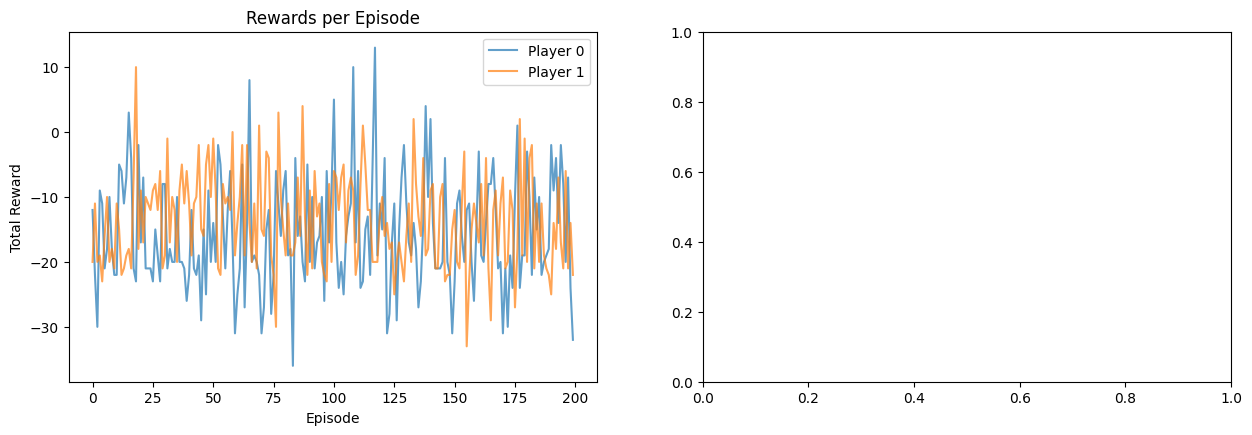

In [15]:
rewards_p0, rewards_p1, win_rates_p0 = train_ppo_self_play("cathedral_ppo_self_play")
    
# Plot results
plt.figure(figsize=(15, 10))

# Plot rewards for both players
plt.subplot(2, 2, 1)
plt.plot(rewards_p0, label='Player 0', alpha=0.7)
plt.plot(rewards_p1, label='Player 1', alpha=0.7)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

# Plot moving average of rewards for better visualization
window = 100
plt.subplot(2, 2, 2)
p0_avg = [np.mean(rewards_p0[max(0, i-window):i+1]) for i in range(len(rewards_p0))]
p1_avg = [np.mean(rewards_p1[max(0, i-window):i+1]) for i in range(len(rewards_p1))]
plt.plot(p0_avg, label='Player 0 (100-ep avg)', alpha=0.7)
plt.plot(p1_avg, label='Player 1 (100-ep avg)', alpha=0.7)
plt.title("Moving Average Rewards (100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

# Plot win rates for player 0
plt.subplot(2, 2, 3)
plt.plot(range(100, num_episodes + 1, 100), win_rates_p0, marker='o')
plt.title("Player 0 Win Rate (per 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.ylim(0, 1)

# Plot win rates for player 1 (deduced from player 0's win rate)
plt.subplot(2, 2, 4)
# Assuming no draws for simplicity in the plot
win_rates_p1 = [1 - wr for wr in win_rates_p0]
plt.plot(range(100, num_episodes + 1, 100), win_rates_p1, marker='o', color='orange')
plt.title("Player 1 Win Rate (per 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("ppo_self_play_training_results.png")
plt.show()